In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(f"Parent directory: {parent_dir}")

Parent directory: /u/weim/lob


In [2]:
# first test: lower batch size 
# results for batch size 6400 are sill ok. LN is not always better than Dirichlet. 
# but in most cases convergence is more stable 

# next test. even lower batch size 3200. 128*25 = 3200
# choose 320 trajectories 

In [8]:
lots_list = [20,60]
n_samples = 10000
train_iter = 200

In [8]:
# testing stuff here 
# import numpy as np
# name = '/u/weim/lob/rewards/flow_60_seed_0_num_iterations_2_bsize_280_log_normal.npz'
# output = np.load(name)['rewards']
# print(output)

In [10]:
lots_list = [20, 60]
n_samples = 10000
train_iter = 400
tag = 'deterministic_action'
batch_size= 12800

folder_path = f"{parent_dir}/rewards"
data = {}
agent_list = ['sl_agent', 'linear_sl_agent',  'dirichlet', 'log_normal']
for env in ['noise', 'flow', 'strategic']:
    data[env] = {}
    for lots in lots_list:
        data[env][lots] = {}
        for agent in agent_list:            
            try: 
                if agent in ['log_normal', 'log_normal_learn_std', 'dirichlet']:                               
                    if tag is not None:
                        name =  f'{folder_path}/{env}_{lots}_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_{train_iter}_bsize_{batch_size}_{agent}_{tag}.npz'
                    else:
                        name =  f'{folder_path}/{env}_{lots}_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_{train_iter}_bsize_{batch_size}_{agent}.npz'
                else:
                    name = f'{folder_path}/{env}_{lots}_episodes_{10000}_eval_seed_100_{agent}.npz'
                print(f'loading from {name}')
                data[env][lots][agent] = np.load(name)['rewards']
            except:
                print(f"path doesnt exist: {name}")
                data[env][lots][agent] = 'no data aviailable'

loading from /u/weim/lob/rewards/noise_20_episodes_10000_eval_seed_100_sl_agent.npz
loading from /u/weim/lob/rewards/noise_20_episodes_10000_eval_seed_100_linear_sl_agent.npz
loading from /u/weim/lob/rewards/noise_20_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_dirichlet_deterministic_action.npz
loading from /u/weim/lob/rewards/noise_20_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_deterministic_action.npz
loading from /u/weim/lob/rewards/noise_60_episodes_10000_eval_seed_100_sl_agent.npz
loading from /u/weim/lob/rewards/noise_60_episodes_10000_eval_seed_100_linear_sl_agent.npz
loading from /u/weim/lob/rewards/noise_60_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_dirichlet_deterministic_action.npz
loading from /u/weim/lob/rewards/noise_60_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_deterministic_action.npz
loading from /u/weim/lob/rewards/flow_20_episodes_10

In [13]:
folder_path = f"{parent_dir}/latex_tables"
list_of_dfs = []
# n_lots = [20, 60]
# print(filler)
for env in ['noise', 'flow', 'strategic']:
    data_for_df = {}
    name_dict = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'dirichlet': 'DR', 'log_normal': 'LN'}
    # agent_names = ['sl_agent', 'linear_sl_agent', 'dirichlet', 'log_normal']
    agent_names = ['sl_agent', 'linear_sl_agent', 'dirichlet', 'log_normal']
    for agent in agent_names:
        print(agent)
        name = name_dict[agent]
        data_for_df[f'E[{name}]'] = []
        data_for_df[f'Std[{name}]'] = []
        for lots in lots_list:
            try:
                data_for_df[f'Std[{name}]'] += [np.std(data[env][lots][agent])]
                data_for_df[f'E[{name}]'] += [np.mean(data[env][lots][agent])]                
            except:
                print(f"no data available for {env}, {lots}, {agent}")
                data_for_df[f'Std[{name}]'] += [np.nan]
                data_for_df[f'E[{name}]'] += [np.nan]
    df = pd.DataFrame.from_dict(data_for_df).round(2)    
    df.index.name = 'Lots'
    index_name = [f'{env}_{l}' for l in lots_list]
    df.index = index_name
    df = df.round(2)
    list_of_dfs.append(df)

complete_df = pd.concat(list_of_dfs, axis=0)
print(complete_df)


highest_exp = []
lowest_std = []
for idx in complete_df.index:
    expected_values = complete_df.loc[idx, ['E[SL]', 'E[TWAP]', 'E[DR]', 'E[LN]']]
    max_idx = expected_values.idxmax()
    highest_exp.append((idx, max_idx))
    std_values = complete_df.loc[idx, ['Std[SL]', 'Std[TWAP]', 'Std[DR]', 'Std[LN]']]
    min_idx = std_values.idxmin()
    lowest_std.append((idx, min_idx))

complete_df = complete_df.astype(str)
for idx, max_idx in highest_exp:
    complete_df.loc[idx, max_idx] = fr"\textbf{{{complete_df.loc[idx, max_idx]}}}"

# dont highlight std for now
# for idx, min_idx in lowest_std:
#     complete_df.loc[idx, min_idx] = fr"\textbf{{{complete_df.loc[idx, min_idx]}}}"

complete_df = complete_df.drop(['noise', 'flow', 'strategic'], errors='ignore')
complete_df.insert(0, r'\#Lots', complete_df.index.astype(str))
complete_df.iloc[:,0] = [20,60]*3

complete_df.insert(0, r'Market', complete_df.index.astype(str))
complete_df.iloc[:,0] = ['Noise', '', 'Noise \& Tactical', '', 'Noise \& Tactical', '\& Strategic']

rename_dict = {'E[SL]': r'$\mathbb{E}[\text{SL}]$', 'Std[SL]': r'$\sigma[\text{SL}]$', 
               'E[TWAP]': r'$\mathbb{E}[\text{TWAP}]$', 'Std[TWAP]': r'$\sigma[\text{TWAP}]$', 
               'E[LN]': r'$\mathbb{E}[\text{LN}]$', 'Std[LN]': r'$\sigma[\text{LN}]$', 
               'E[DR]': r'$\mathbb{E}[\text{DR}]$', 'Std[DR]': r'$\sigma[\text{DR}]$',
            #    'E[LNVAR]': r'$\mathbb{E}[\text{LNVAR}]$', 'Std[LNVAR]': r'$\sigma[\text{LNVAR}]$'
               }
print(complete_df)
complete_df = complete_df.rename(columns=rename_dict)
complete_df = complete_df.where(pd.notnull(complete_df), '')

latex_table = complete_df.to_latex(float_format="%.2f", index=False, column_format='l'+'c'*9, escape=False)
saving_path = f"{folder_path}/results_table_latest_with_dirichlet_{tag}.tex" if tag is not None else f"{folder_path}/results_table_latest_with_dirichlet.tex"
tag = 'determininstic_action'
saving_path = f"{folder_path}/results_table_log_normal_{tag}_new_feature.tex" 
tag = '' if tag is None else tag
with open(saving_path, "w") as f:
    content = (
        r"\begin{table}[htpb]"+
        r"\label{table:" + tag +"}"+
        r"\begin{center}"+
        r"    \begin{scriptsize}"+
        r"        \begin{sc}"
        + latex_table +
        r"        \end{sc}"+
        r"    \end{scriptsize}"+
        r"\end{center}"+
        r"\end{table}"        
    )
    f.write(content)




sl_agent
linear_sl_agent
dirichlet
log_normal
sl_agent
linear_sl_agent
dirichlet
log_normal
sl_agent
linear_sl_agent
dirichlet
log_normal
              E[SL]  Std[SL]  E[TWAP]  Std[TWAP]  E[DR]  Std[DR]  E[LN]  \
noise_20       0.52     1.19    -0.06       0.94   0.22     0.79   0.62   
noise_60      -1.09     1.34    -1.40       0.98  -0.71     0.94  -0.72   
flow_20        0.10     1.43     0.48       0.68   0.77     0.64   0.79   
flow_60       -3.36     0.99    -0.96       0.95  -0.23     0.64  -0.22   
strategic_20  -1.64     2.95    -0.36       3.03   1.01     2.16   1.13   
strategic_60  -2.51     3.67    -1.45       3.46   0.03     1.97   0.19   

              Std[LN]  
noise_20         1.01  
noise_60         0.97  
flow_20          0.63  
flow_60          0.64  
strategic_20     2.22  
strategic_60     2.37  
                         Market \#Lots  E[SL] Std[SL] E[TWAP] Std[TWAP]  \
noise_20                  Noise     20   0.52    1.19   -0.06      0.94   
noise_60          

In [8]:
### this box is for learned variance strategies 

folder_path = f"{parent_dir}/latex_tables"
list_of_dfs = []
# n_lots = [20, 60]
# print(filler)
for env in ['noise', 'flow', 'strategic']:
    data_for_df = {}
    # agent_names = ['sl_agent', 'linear_sl_agent', 'dirichlet', 'log_normal']
    agent_names = ['sl_agent', 'linear_sl_agent', 'log_normal_learn_std', 'log_normal']
    name_dict = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'dirichlet': 'DR', 'log_normal_learn_std': 'LNVR', 'log_normal': 'LN'}
    for agent in agent_names:
        print(agent)
        name = name_dict[agent]
        data_for_df[f'E[{name}]'] = []
        data_for_df[f'Std[{name}]'] = []
        for lots in lots_list:
            try:
                data_for_df[f'Std[{name}]'] += [np.std(data[env][lots][agent])]
                data_for_df[f'E[{name}]'] += [np.mean(data[env][lots][agent])]                
            except:
                print(f"no data available for {env}, {lots}, {agent}")
                data_for_df[f'Std[{name}]'] += [np.nan]
                data_for_df[f'E[{name}]'] += [np.nan]
    df = pd.DataFrame.from_dict(data_for_df).round(2)    
    df.index.name = 'Lots'
    index_name = [f'{env}_{l}' for l in lots_list]
    df.index = index_name
    df = df.round(2)
    list_of_dfs.append(df)

complete_df = pd.concat(list_of_dfs, axis=0)
print(complete_df)


highest_exp = []
lowest_std = []
for idx in complete_df.index:
    expected_values = complete_df.loc[idx, ['E[SL]', 'E[TWAP]', 'E[LNVR]', 'E[LN]']]
    max_idx = expected_values.idxmax()
    highest_exp.append((idx, max_idx))
    std_values = complete_df.loc[idx, ['Std[SL]', 'Std[TWAP]', 'Std[LNVR]', 'Std[LN]']]
    min_idx = std_values.idxmin()
    lowest_std.append((idx, min_idx))

complete_df = complete_df.astype(str)
for idx, max_idx in highest_exp:
    complete_df.loc[idx, max_idx] = fr"\textbf{{{complete_df.loc[idx, max_idx]}}}"

# dont highlight std for now
# for idx, min_idx in lowest_std:
#     complete_df.loc[idx, min_idx] = fr"\textbf{{{complete_df.loc[idx, min_idx]}}}"

complete_df = complete_df.drop(['noise', 'flow', 'strategic'], errors='ignore')
complete_df.insert(0, r'\#Lots', complete_df.index.astype(str))
complete_df.iloc[:,0] = [20,60]*3

complete_df.insert(0, r'Market', complete_df.index.astype(str))
complete_df.iloc[:,0] = ['Noise', '', 'Noise \& Tactical', '', 'Noise \& Tactical', '\& Strategic']

rename_dict = {'E[SL]': r'$\mathbb{E}[\text{SL}]$', 'Std[SL]': r'$\sigma[\text{SL}]$', 
               'E[TWAP]': r'$\mathbb{E}[\text{TWAP}]$', 'Std[TWAP]': r'$\sigma[\text{TWAP}]$', 
               'E[LN]': r'$\mathbb{E}[\text{LN}]$', 'Std[LN]': r'$\sigma[\text{LN}]$', 
            #    'E[DR]': r'$\mathbb{E}[\text{DR}]$', 'Std[DR]': r'$\sigma[\text{DR}]$',
               'E[LNVAR]': r'$\mathbb{E}[\text{LNVAR}]$', 'Std[LNVAR]': r'$\sigma[\text{LNVAR}]$'
               }
print(complete_df)
complete_df = complete_df.rename(columns=rename_dict)
complete_df = complete_df.where(pd.notnull(complete_df), '')

latex_table = complete_df.to_latex(float_format="%.2f", index=False, column_format='l'+'c'*9, escape=False)
saving_path = f"{folder_path}/results_table_latest_with_dirichlet_{tag}.tex" if tag is not None else f"{folder_path}/results_table_latest_with_dirichlet.tex"
tag = 'learned_variance'
saving_path = f"{folder_path}/results_table_log_normal_deterministic_action_{tag}.tex" 
tag = '' if tag is None else tag
with open(saving_path, "w") as f:
    content = (
        r"\begin{table}[htpb]"+
        r"\label{table:" + tag +"}"+
        r"\begin{center}"+
        r"    \begin{scriptsize}"+
        r"        \begin{sc}"
        + latex_table +
        r"        \end{sc}"+
        r"    \end{scriptsize}"+
        r"\end{center}"+
        r"\end{table}"        
    )
    f.write(content)




sl_agent
linear_sl_agent
log_normal_learn_std
log_normal
sl_agent
linear_sl_agent
log_normal_learn_std
log_normal
sl_agent
linear_sl_agent
log_normal_learn_std
log_normal
              E[SL]  Std[SL]  E[TWAP]  Std[TWAP]  E[LNVR]  Std[LNVR]  E[LN]  \
noise_20       0.52     1.19    -0.06       0.94     0.64       0.93   0.61   
noise_60      -1.09     1.34    -1.40       0.98    -0.77       0.99  -0.72   
flow_20        0.10     1.43     0.48       0.68     0.74       0.70   0.81   
flow_60       -3.36     0.99    -0.96       0.95    -0.41       0.69  -0.25   
strategic_20  -1.64     2.95    -0.36       3.03     1.15       2.14   1.13   
strategic_60  -2.51     3.67    -1.45       3.46     0.14       2.04   0.23   

              Std[LN]  
noise_20         1.03  
noise_60         0.90  
flow_20          0.64  
flow_60          0.67  
strategic_20     2.08  
strategic_60     2.15  
                         Market \#Lots  E[SL] Std[SL] E[TWAP] Std[TWAP]  \
noise_20                  Noise 

#############
generating plots for  noise
saving to /u/weim/lob/plots/reward_distribution_noise_deterministic_action.pdf
#############
generating plots for  flow
saving to /u/weim/lob/plots/reward_distribution_flow_deterministic_action.pdf
#############
generating plots for  strategic
saving to /u/weim/lob/plots/reward_distribution_strategic_deterministic_action.pdf


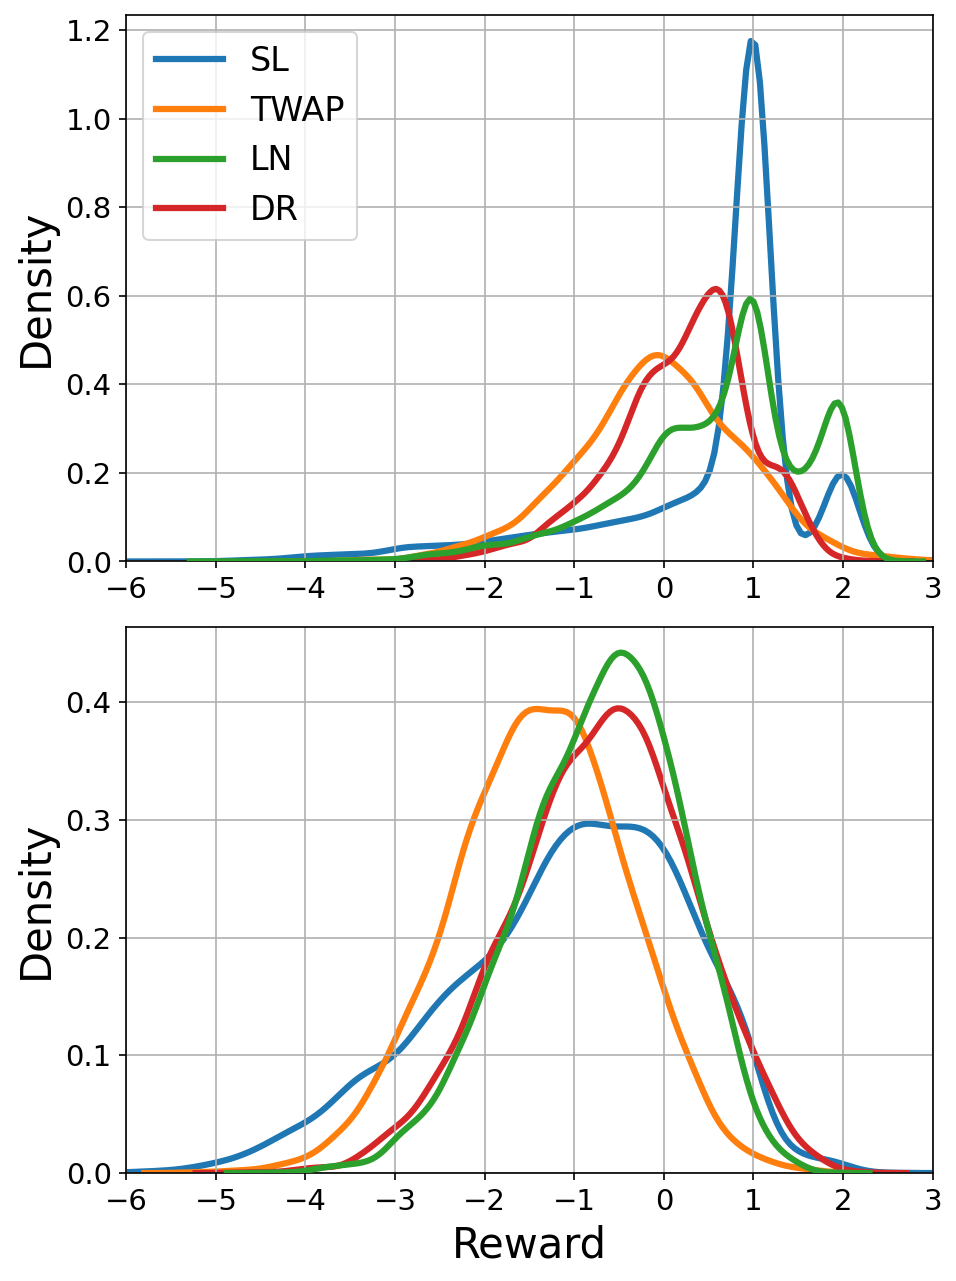

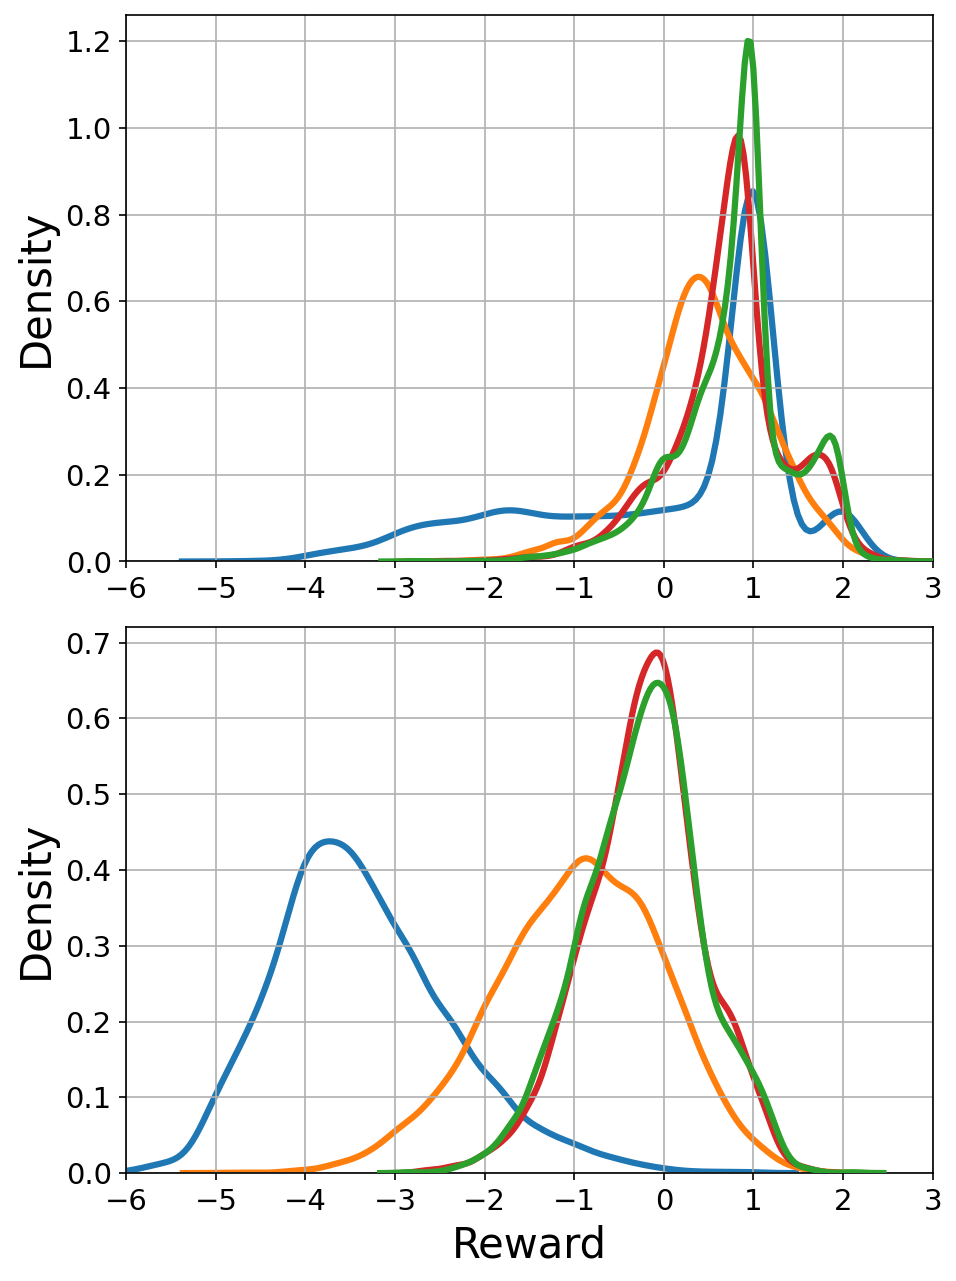

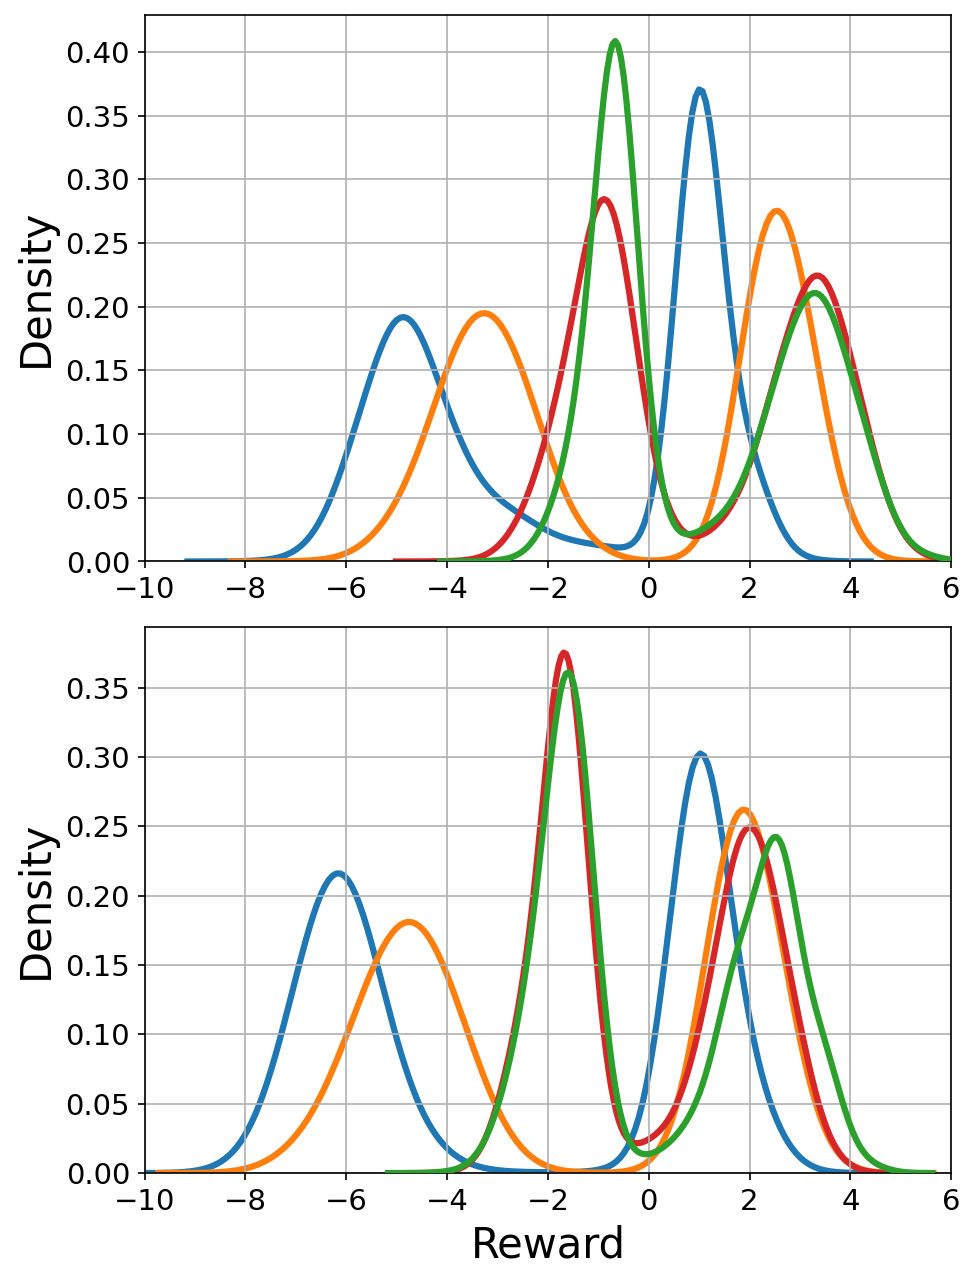

In [6]:
### density plot for deterministic actions 

lots_list = [20, 60]
textwidth = 6.75
textheight = 9
scale = 3.2

agent_names = ['sl_agent', 'linear_sl_agent', 'log_normal', 'dirichlet']
# without dirichlet
# this yields the correct ordering in the maps 
# agent_names = ['sl_agent', 'linear_sl_agent',  'log_normal', 'log_normal_learn_std']
# agent_names = ['sl_agent', 'linear_sl_agent', 'log_normal']
# agent_names = ['log_normal', 'sl_agent', 'linear_sl_agent']
for i, env in enumerate(['noise', 'flow', 'strategic']):
    print('#############')
    print('generating plots for ', env)
    fig, axs = plt.subplots(2, 1, figsize=(scale*0.3*textwidth, scale*0.3*textheight), dpi=300)
    for j, lots in enumerate(lots_list):
        ax = axs[j]
        for agent in agent_names:
            # names = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'actor_critic': 'RL'} 
            name_translation = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'log_normal': 'LN', 'dirichlet': 'DR', 'log_normal_learn_std': 'LNVR'}
            try: 
                if agent == 'log_normal':
                    z_order = 10
                else:
                    z_order = 1 
                sns.kdeplot(data[env][lots][agent], fill=False, label=name_translation[agent], bw_adjust=1, linewidth=3, ax=ax, zorder=z_order)
            except: 
                print(f"no data available for {env}, {lots}, {agent}")
        if env == 'noise' and lots == 20:   
            ax.legend(prop={'size': 16}, loc='upper left')
        # set legend at the top of ech market. can comment this out if necessary. 
        # if j == 0:
            # ax.legend(prop={'size': 16}, loc='upper left')  
        fig.set_dpi(150)
        if j == 1:
            ax.set_xlabel('Reward', fontsize=20)
            # ax.set_xlabel('X', fontsize=20)
        # ax.set_title(f'{env}', fontsize=18)
        if i == 0:
            ax.set_ylabel('Density', fontsize=20)
        else:
            ax.set_ylabel('')
        # set density label everywhere
        # comment out if necessary 
        ax.set_ylabel('Density', fontsize=20)
        # if i == 0:
            # ax.set_title(f'Noise', fontsize=18)
        # if j == 0:
        # ax.set_title(f'#Lots={n_lots}', fontsize=18)
        tick_size = 14
        ax.tick_params(axis='x', labelsize=tick_size)
        ax.tick_params(axis='y', labelsize=tick_size)
        ax.grid()
        ax.set_xticks(np.arange(-10, 10, 1))
        if env == 'flow':
            ax.set_xlim(-6, 3)
        elif env == 'strategic':
            ax.set_xticks(np.arange(-12, 12, 2))
            ax.set_xlim(-10, 6)
        else:
            # adjust xlim depending on experiments manually 
            ax.set_xlim(-6, 3)
    plt.tight_layout() 
    tag = 'deterministic_action'
    name = f'{parent_dir}/plots/reward_distribution_{env}_{tag}.pdf'
    print(f'saving to {name}')
    plt.savefig(name)




In [ ]:
# results look similar and sometimes even slightly better when using DETERMINISTIC actions 

# medium batch results are not as good as large batch results 
# tag = 'small_batch'
# tag = 'small_batch_GAE'
# tag = 'medium_batch'

folder_path = f"{parent_dir}/latex_tables"
list_of_dfs = []
# n_lots = [20, 60]
# print(filler)


for env in ['noise', 'flow', 'strategic']:
    data_for_df = {}
    name_dict = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'dirichlet': 'DR', 'log_normal': 'LN', 'log_normal_learn_std': 'LNVAR'}
    # agent_names = ['sl_agent', 'linear_sl_agent', 'dirichlet', 'log_normal']
    agent_names = ['sl_agent', 'linear_sl_agent', 'log_normal', 'log_normal_learn_std']
    for agent in agent_names:
        print(agent)
        name = name_dict[agent]
        data_for_df[f'E[{name}]'] = []
        data_for_df[f'Std[{name}]'] = []
        for lots in lots_list:
            try:
                data_for_df[f'Std[{name}]'] += [np.std(data[env][lots][agent])]
                data_for_df[f'E[{name}]'] += [np.mean(data[env][lots][agent])]                
            except:
                print(f"no data available for {env}, {lots}, {agent}")
                data_for_df[f'Std[{name}]'] += [np.nan]
                data_for_df[f'E[{name}]'] += [np.nan]
    df = pd.DataFrame.from_dict(data_for_df).round(2)    
    df.index.name = 'Lots'
    index_name = [f'{env}_{l}' for l in lots_list]
    df.index = index_name
    df = df.round(2)
    list_of_dfs.append(df)

complete_df = pd.concat(list_of_dfs, axis=0)
print(complete_df)


highest_exp = []
lowest_std = []
for idx in complete_df.index:
    # expected_values = complete_df.loc[idx, ['E[SL]', 'E[TWAP]', 'E[DR]', 'E[LN]']]
    expected_values = complete_df.loc[idx, ['E[SL]', 'E[TWAP]', 'E[LN]', 'E[LNVAR]']]
    max_idx = expected_values.idxmax()
    highest_exp.append((idx, max_idx))
    # std_values = complete_df.loc[idx, ['Std[SL]', 'Std[TWAP]', 'Std[DR]', 'Std[LN]']]
    std_values = complete_df.loc[idx, ['Std[SL]', 'Std[TWAP]', 'Std[LN]', 'Std[LNVAR]']]
    min_idx = std_values.idxmin()
    lowest_std.append((idx, min_idx))

complete_df = complete_df.astype(str)
for idx, max_idx in highest_exp:
    complete_df.loc[idx, max_idx] = fr"\textbf{{{complete_df.loc[idx, max_idx]}}}"

for idx, min_idx in lowest_std:
    complete_df.loc[idx, min_idx] = fr"\textbf{{{complete_df.loc[idx, min_idx]}}}"

complete_df = complete_df.drop(['noise', 'flow', 'strategic'], errors='ignore')
complete_df.insert(0, r'\#Lots', complete_df.index.astype(str))
complete_df.iloc[:,0] = [20,60]*3

complete_df.insert(0, r'Market', complete_df.index.astype(str))
complete_df.iloc[:,0] = ['Noise', '', 'Noise \& Tactical', '', 'Noise \& Tactical', '\& Strategic']

rename_dict = {'E[SL]': r'$\mathbb{E}[\text{SL}]$', 'Std[SL]': r'$\sigma[\text{SL}]$', 
               'E[TWAP]': r'$\mathbb{E}[\text{TWAP}]$', 'Std[TWAP]': r'$\sigma[\text{TWAP}]$', 
               'E[LN]': r'$\mathbb{E}[\text{LN}]$', 'Std[LN]': r'$\sigma[\text{LN}]$', 
               'E[DR]': r'$\mathbb{E}[\text{DR}]$', 'Std[DR]': r'$\sigma[\text{DR}]$',
               'E[LNVAR]': r'$\mathbb{E}[\text{LNVAR}]$', 'Std[LNVAR]': r'$\sigma[\text{LNVAR}]$'
               }
print(complete_df)
complete_df = complete_df.rename(columns=rename_dict)
complete_df = complete_df.where(pd.notnull(complete_df), '')

latex_table = complete_df.to_latex(float_format="%.2f", index=False, column_format='l'+'c'*9, escape=False)
saving_path = f"{folder_path}/results_table_latest_with_dirichlet_{tag}.tex" if tag is not None else f"{folder_path}/results_table_latest_with_dirichlet.tex"
saving_path = f"{folder_path}/results_table_log_normal_learn_std.tex" 
tag = '' if tag is None else tag
with open(saving_path, "w") as f:
    content = (
        r"\begin{table}[htpb]"+
        r"\label{table:" + tag +"}"+
        r"\begin{center}"+
        r"    \begin{scriptsize}"+
        r"        \begin{sc}"
        + latex_table +
        r"        \end{sc}"+
        r"    \end{scriptsize}"+
        r"\end{center}"+
        r"\end{table}"        
    )
    f.write(content)


sl_agent
linear_sl_agent
log_normal
log_normal_learn_std
no data available for noise, 40, log_normal_learn_std
no data available for noise, 120, log_normal_learn_std
sl_agent
linear_sl_agent
log_normal
log_normal_learn_std
no data available for flow, 40, log_normal_learn_std
no data available for flow, 120, log_normal_learn_std
sl_agent
linear_sl_agent
log_normal
log_normal_learn_std
no data available for strategic, 40, log_normal_learn_std
no data available for strategic, 120, log_normal_learn_std
               E[SL]  Std[SL]  E[TWAP]  Std[TWAP]  E[LN]  Std[LN]  E[LNVAR]  \
noise_40       -0.35     1.43    -0.58       1.10   0.29     1.01       NaN   
noise_120      -2.75     1.29    -3.02       1.06  -1.66     1.24       NaN   
flow_40        -2.00     1.43    -0.19       1.00   0.53     0.70       NaN   
flow_120       -5.57     0.77    -4.13       1.03  -0.86     0.78       NaN   
strategic_40   -2.11     3.29    -1.09       3.28   1.60     3.41       NaN   
strategic_120  -3.96  

In [16]:
complete_df.iloc[:, 4:]

,$\mathbb{E}[\text{TWAP}]$,$\sigma[\text{TWAP}]$,$\mathbb{E}[\text{DR}]$,$\sigma[\text{DR}]$,$\mathbb{E}[\text{LN}]$,$\sigma[\text{LN}]$
noise_20,-0.06,0.94,0.46,0.91,\textbf{0.64},\textbf{0.88}
noise_60,-1.4,0.98,\textbf{-0.79},0.98,-0.81,\textbf{0.93}
flow_20,0.48,0.68,0.72,\textbf{0.67},\textbf{0.79},0.67
flow_60,-0.96,0.95,-0.34,\textbf{0.66},\textbf{-0.24},0.66
strategic_20,-0.36,3.03,1.01,\textbf{2.12},\textbf{1.11},2.23
strategic_60,-1.45,3.46,0.03,\textbf{1.99},\textbf{0.11},2.42


In [17]:
import numpy as np
from scipy import stats

alpha = 1e-1
for env in ['flow', 'strategic']:
    for lots in lots_list:
        print('####')
        print(f'{env} {lots_list}: ')
        try:
            group1 = data[env][lots]['linear_sl_agent']
            group2 = data[env][lots]['actor_critic']
            t_statistic, p_value = stats.ttest_ind(group1, group2)
            print(f"linear_sl vs rl: t-statistic: {t_statistic}, p-value: {p_value}")
            if p_value < alpha:
                print("The means are statistically different.")
            else:
                print("The means are not statistically different.")
        except:
            print(f"no data available for {env}, {lots_list}, linear_sl vs rl")
        # print()


####
flow [20, 60]: 
no data available for flow, [20, 60], linear_sl vs rl
####
flow [20, 60]: 
no data available for flow, [20, 60], linear_sl vs rl
####
strategic [20, 60]: 
no data available for strategic, [20, 60], linear_sl vs rl
####
strategic [20, 60]: 
no data available for strategic, [20, 60], linear_sl vs rl


tag is 


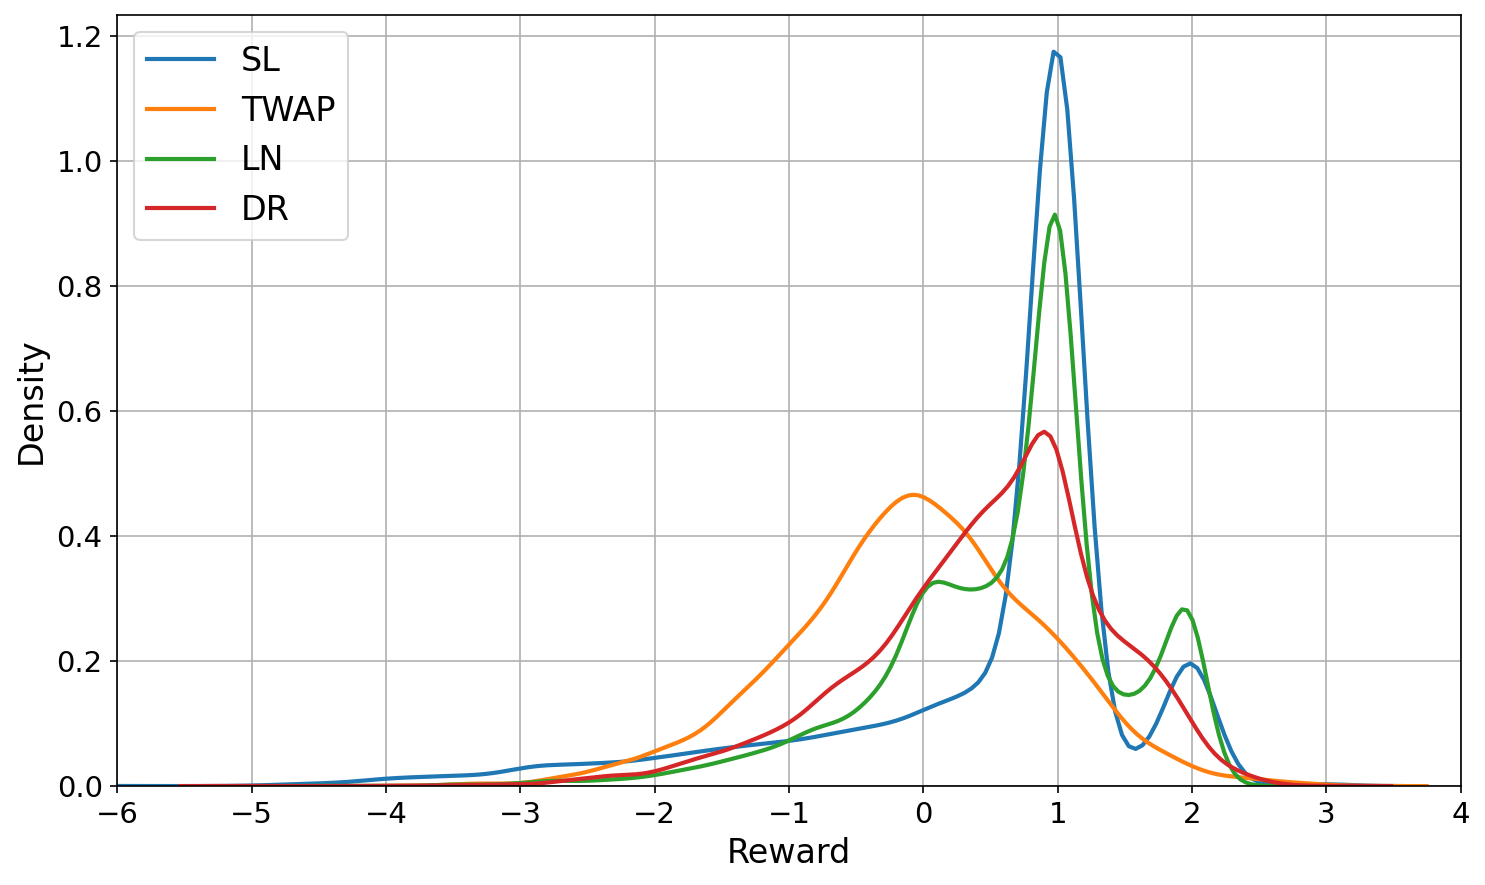

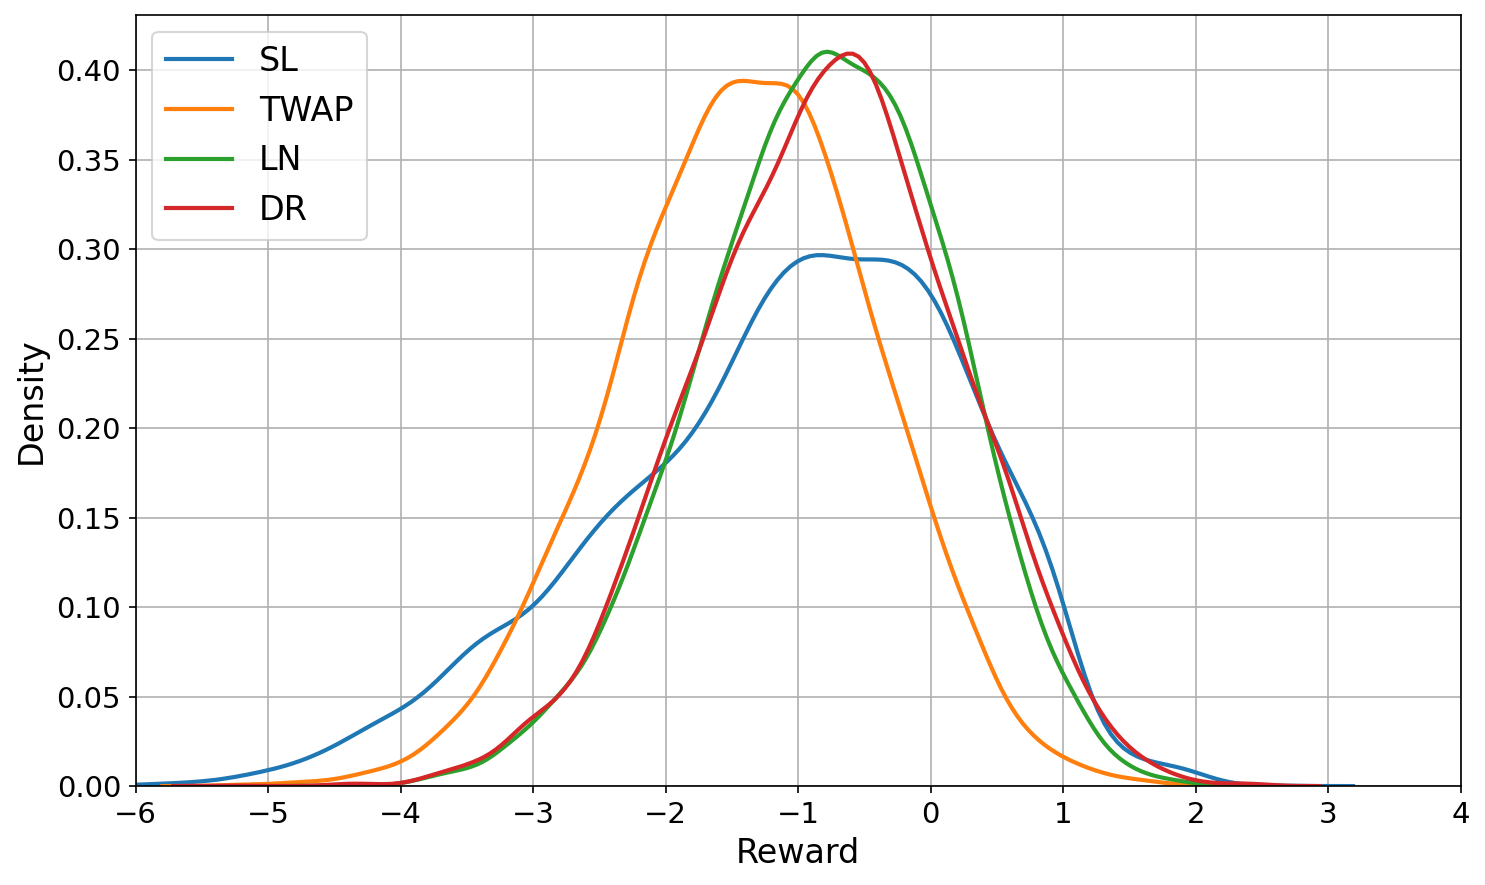

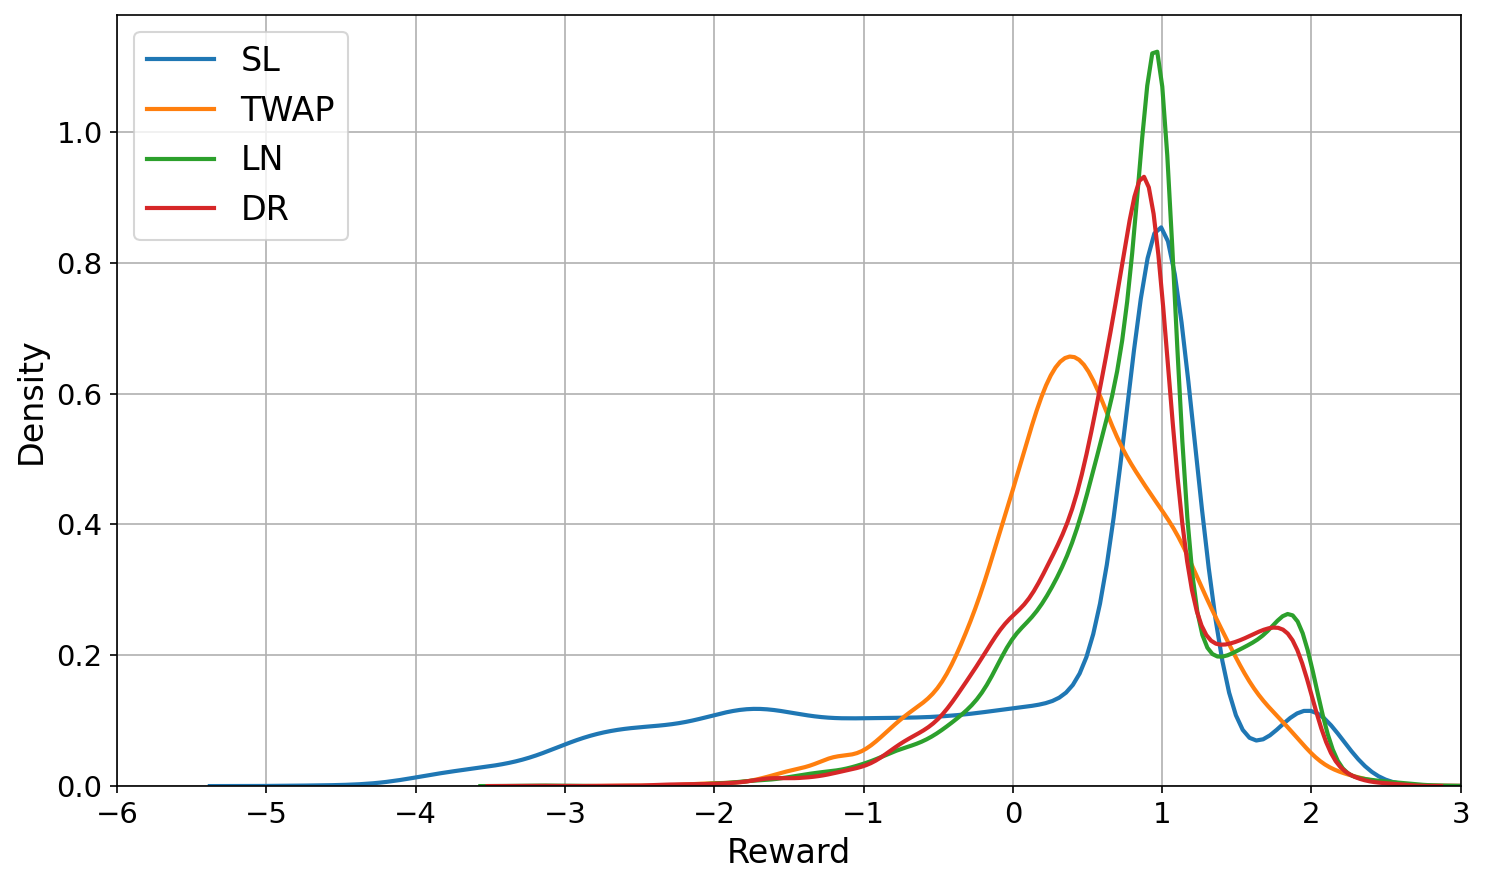

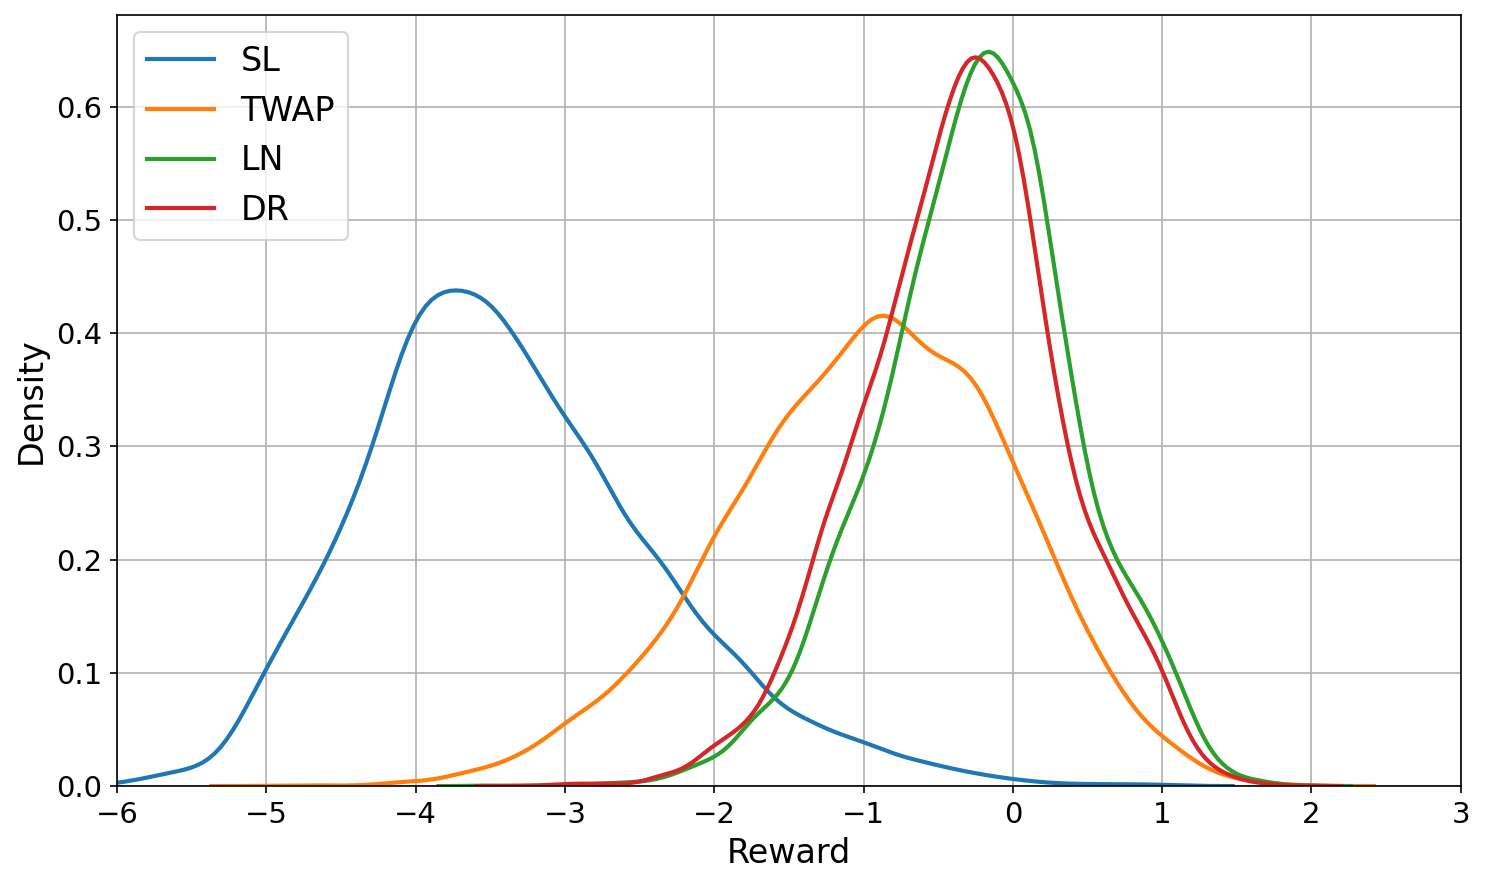

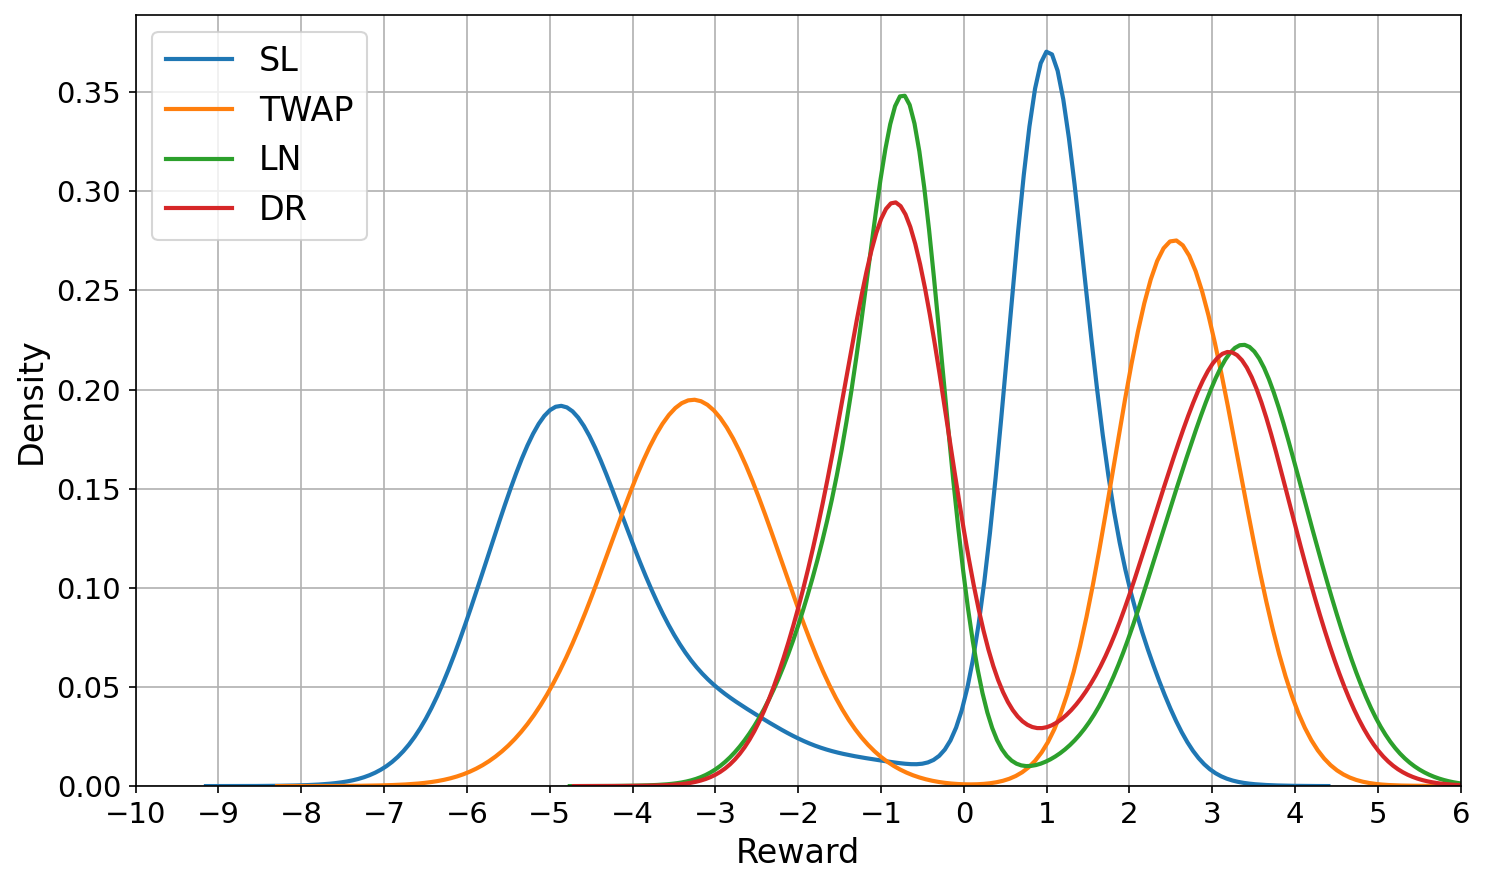

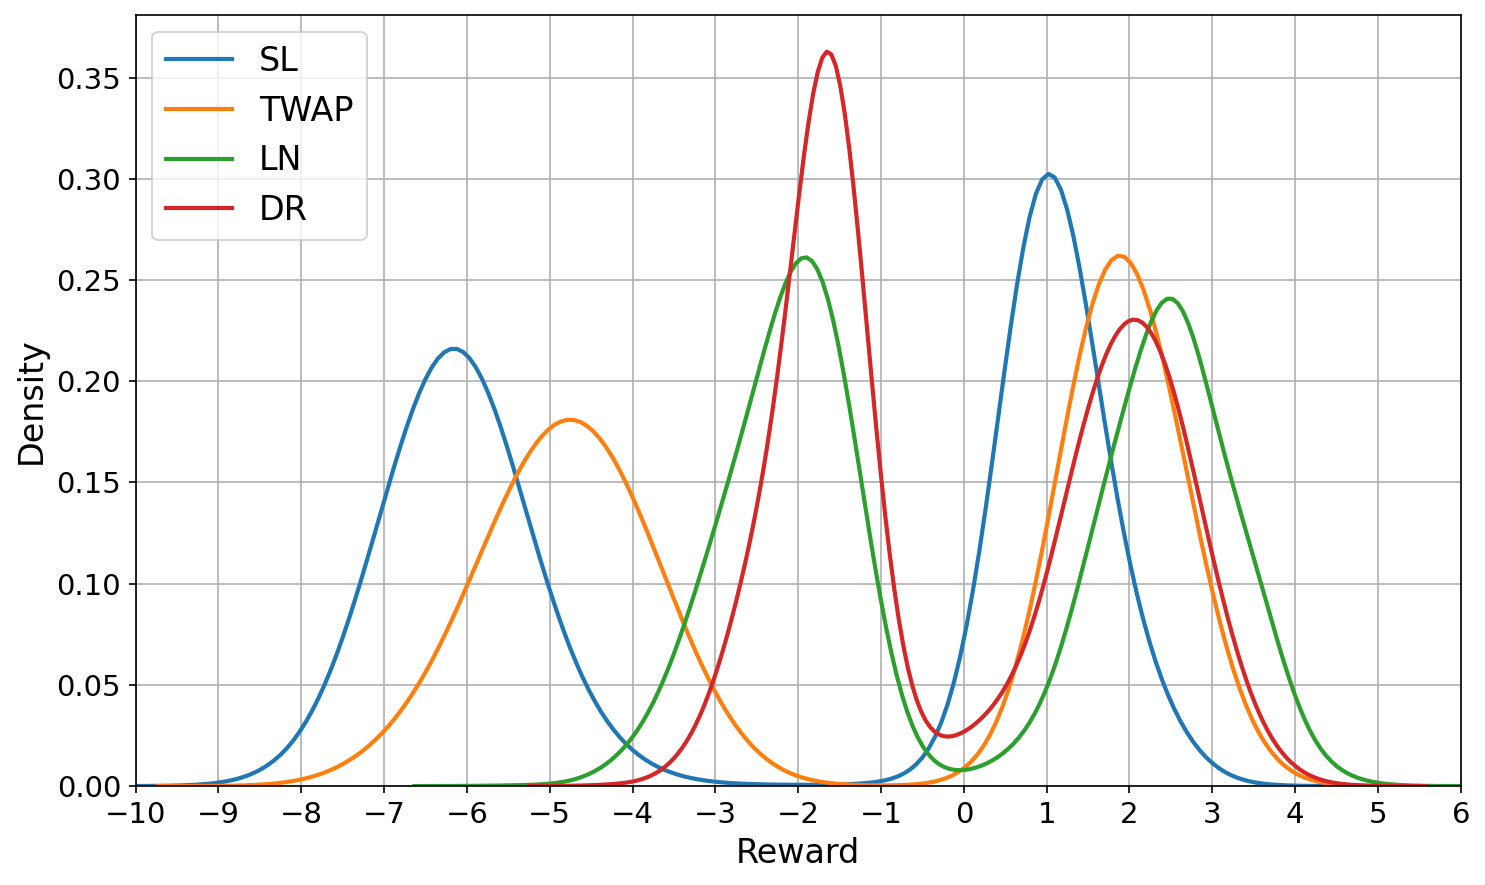

In [18]:
# tag = 'small_batch'
# tag = 'small_batch_GAE'
print(f'tag is {tag}')
agent_names = ['sl_agent', 'linear_sl_agent', 'log_normal', 'dirichlet']
for env in ['noise', 'flow', 'strategic']:
    for lots in lots_list:
        fig, ax = plt.subplots(figsize=(10, 6))
        for agent in agent_names:
            # names = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'actor_critic': 'RL'} 
            translate_names = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'log_normal': 'LN', 'dirichlet': 'DR'}
            try: 
                sns.kdeplot(data[env][lots][agent], fill=False, label=translate_names[agent], bw_adjust=1, linewidth=2)
            except:
                print(f"no data available for {env}, {lots}, {agent}")
            # plt.tight_layout()
            # plt.savefig('plots/mid_price_drift.pdf')
            # ax.set_xticks(np.arange(-4, 4.5, 0.5))
            # ax.tick_params(axis='x', labelsize=7)
        ax.legend(prop={'size': 16}, loc='upper left')
        fig.set_dpi(150)
        # ax.set_title(f'{lots} lots, {env}', fontsize=18)
        ax.set_xlabel('Reward', fontsize=16)
        ax.set_ylabel('Density', fontsize=16)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        plt.grid()
        ax.set_xticks(np.arange(-10, 10, 1))
        if env == 'flow':
            plt.xlim(-6, 3)
        elif env == 'strategic':
            plt.xlim(-10, 6)
        else:
            plt.xlim(-6, 4)
        plt.tight_layout()
        plt.savefig(f'{parent_dir}/plots/reward_distribution_{env}_{lots_list}_with_dirichlet.pdf')

[20, 60]


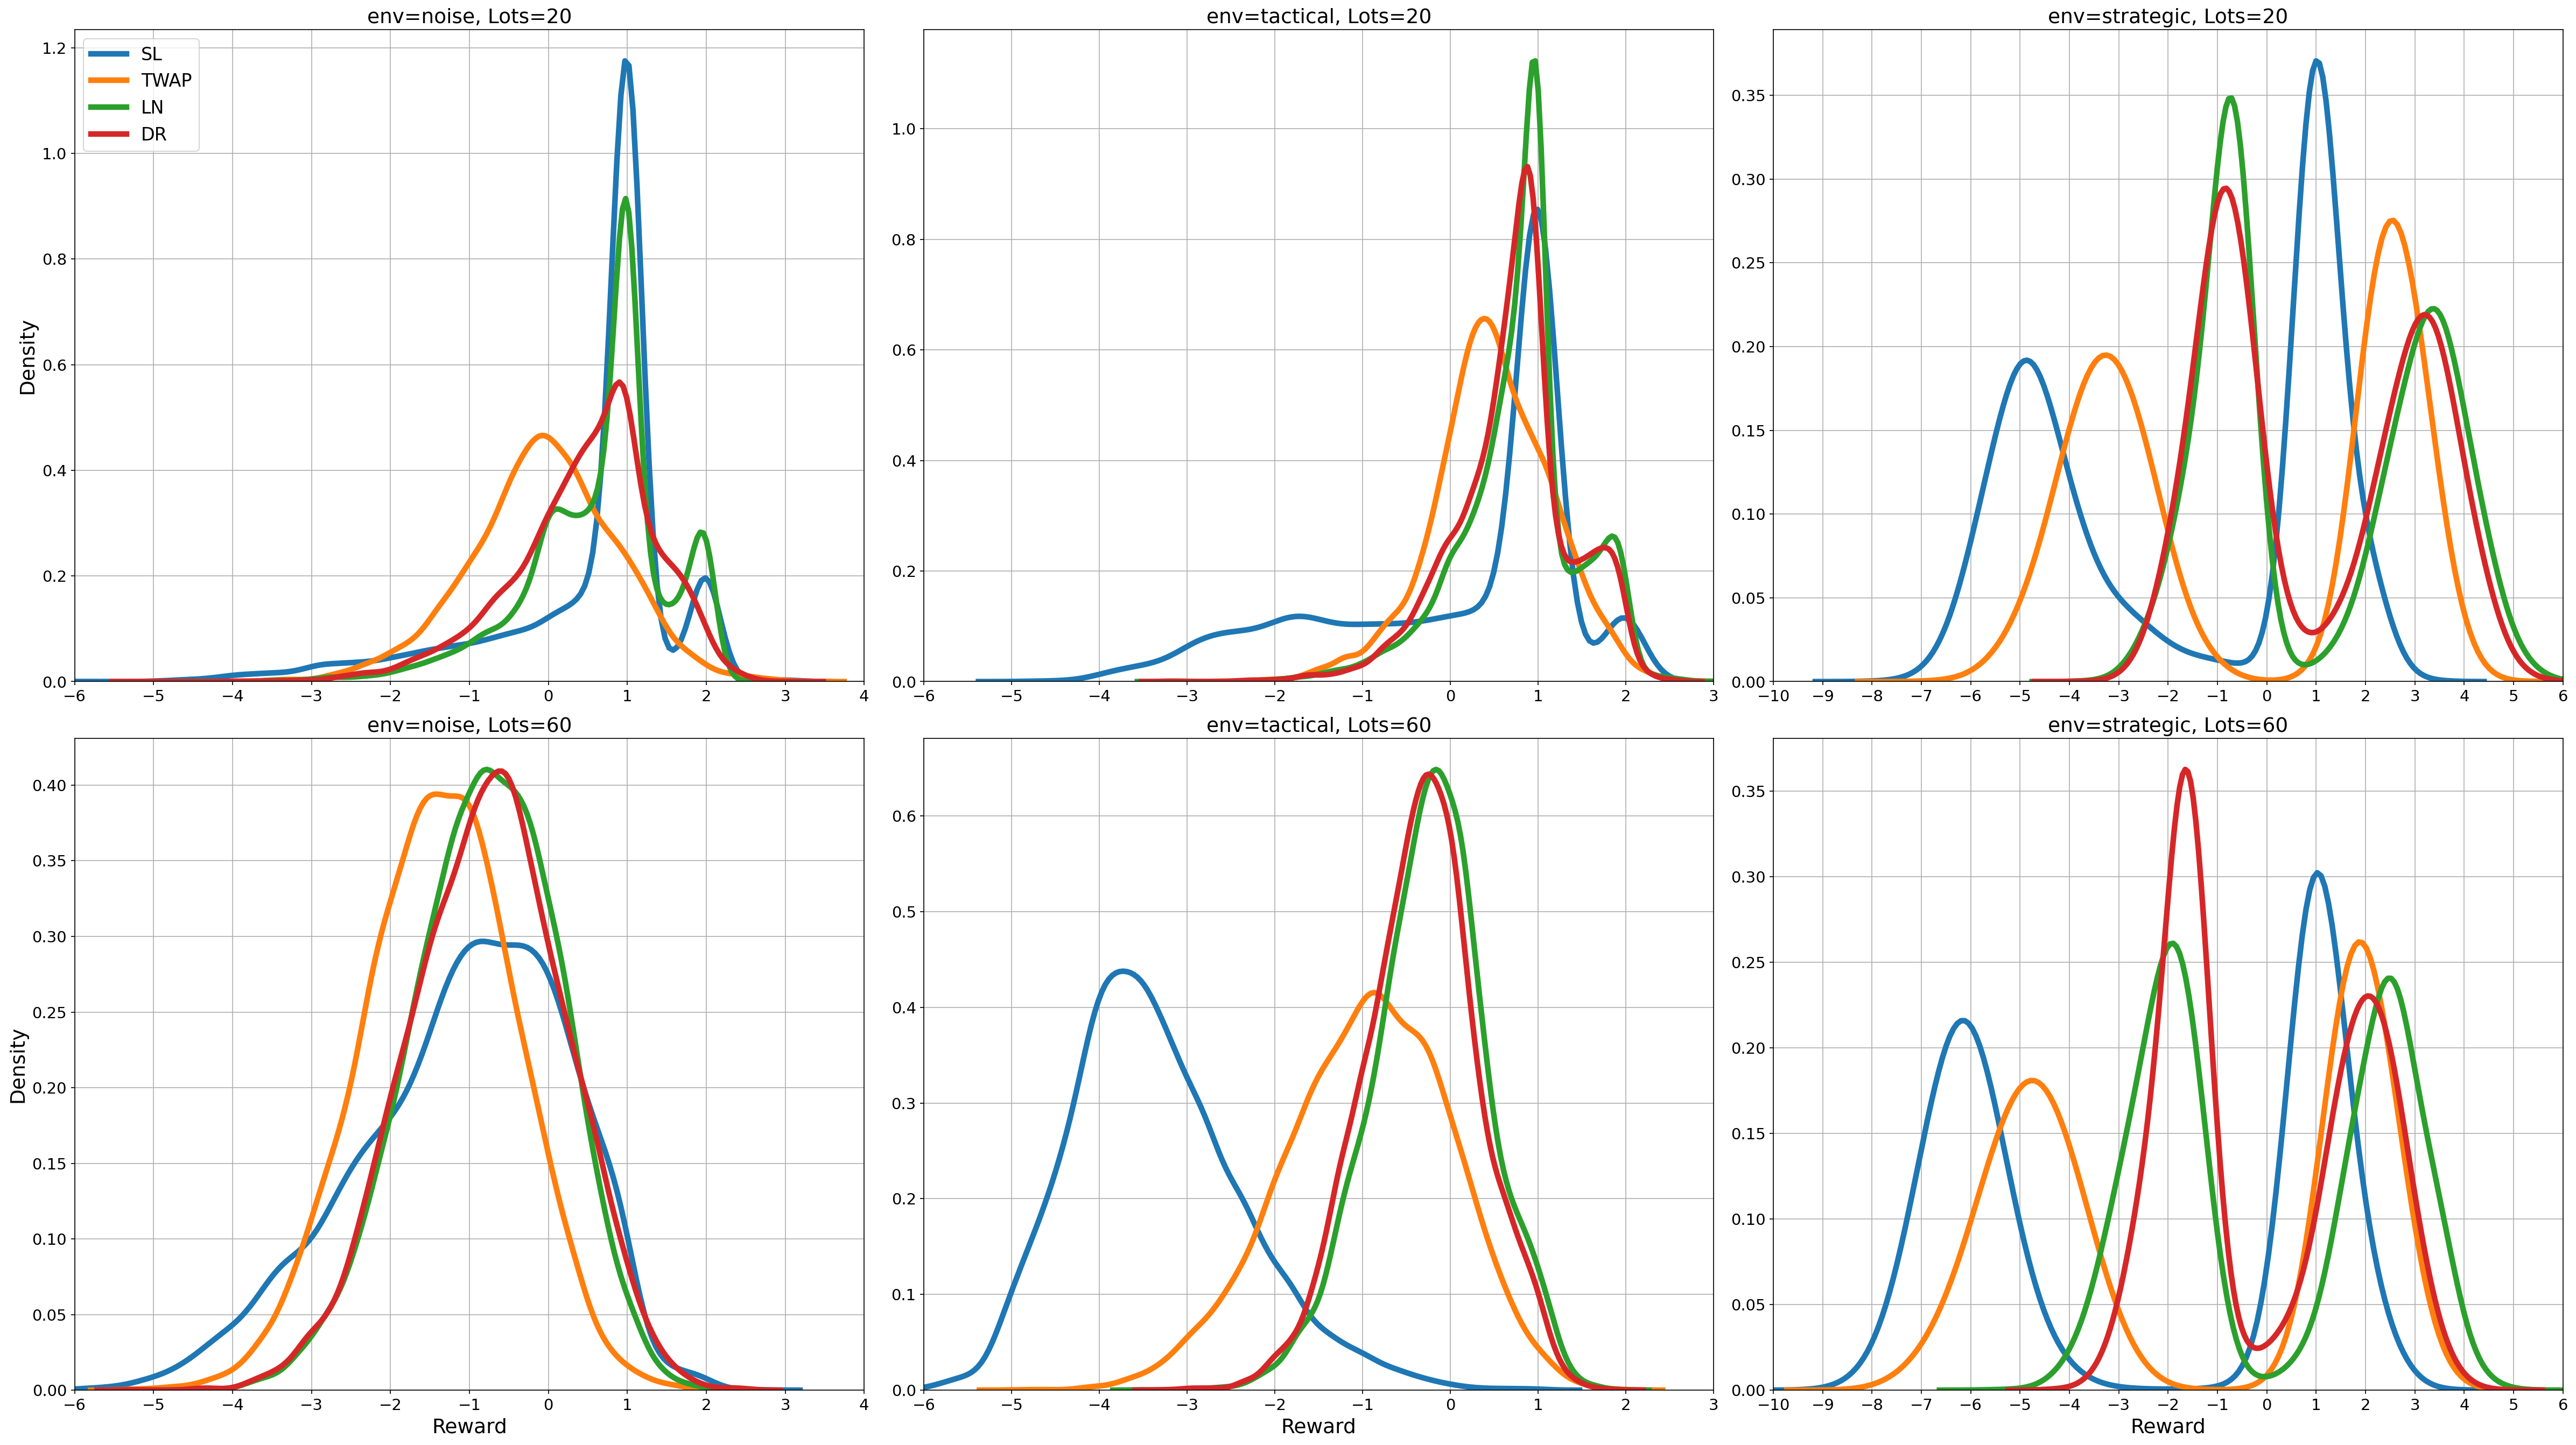

In [19]:
# lots = [20, 60]
# lots_list = [10, 50]
print(lots_list)
fig, axs = plt.subplots(2, 3, figsize=(2*16, 2*9), dpi=300)
for i, env in enumerate(['noise', 'flow', 'strategic']):
    for j, lots in enumerate(lots_list):
        ax = axs[j, i]
        for agent in ['sl_agent', 'linear_sl_agent', 'log_normal', 'dirichlet']:
            names = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'log_normal': 'LN', 'dirichlet': 'DR'}
            try:
                sns.kdeplot(data[env][lots][agent], fill=False, label=names[agent], bw_adjust=1, linewidth=5, ax=ax)
            except: 
                print(f"no data available for {env}, {lots}, {agent}")
        if env == 'noise' and lots == 20:
            ax.legend(prop={'size': 16}, loc='upper left')
        fig.set_dpi(150)
        if j == 1:
            ax.set_xlabel('Reward', fontsize=18)
        # ax.set_title(f'{env}', fontsize=18)
        if i == 0:
            ax.set_ylabel('Density', fontsize=18)
        else:
            ax.set_ylabel('')
        if i == 0:
            ax.set_title(f'Noise', fontsize=18)
        # if i == 0:
            # if j==1:
        if env == 'flow':
            ax.set_title(f'env=tactical, Lots={lots}', fontsize=18)
        else:
            ax.set_title(f'env={env}, Lots={lots}', fontsize=18)
        # if j == 0:
        # ax.set_title(f'#Lots={n_lots}', fontsize=18)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.grid()
        ax.set_xticks(np.arange(-10, 10, 1))
        if env == 'flow':
            ax.set_xlim(-6, 3)
        elif env == 'strategic':
            ax.set_xlim(-10, 6)
        else:
            ax.set_xlim(-6, 4)
plt.tight_layout()
plt.savefig(f'{parent_dir}/plots/reward_distribution_combined.pdf')

#############
generating plots for  noise
#############
generating plots for  flow
#############
generating plots for  strategic


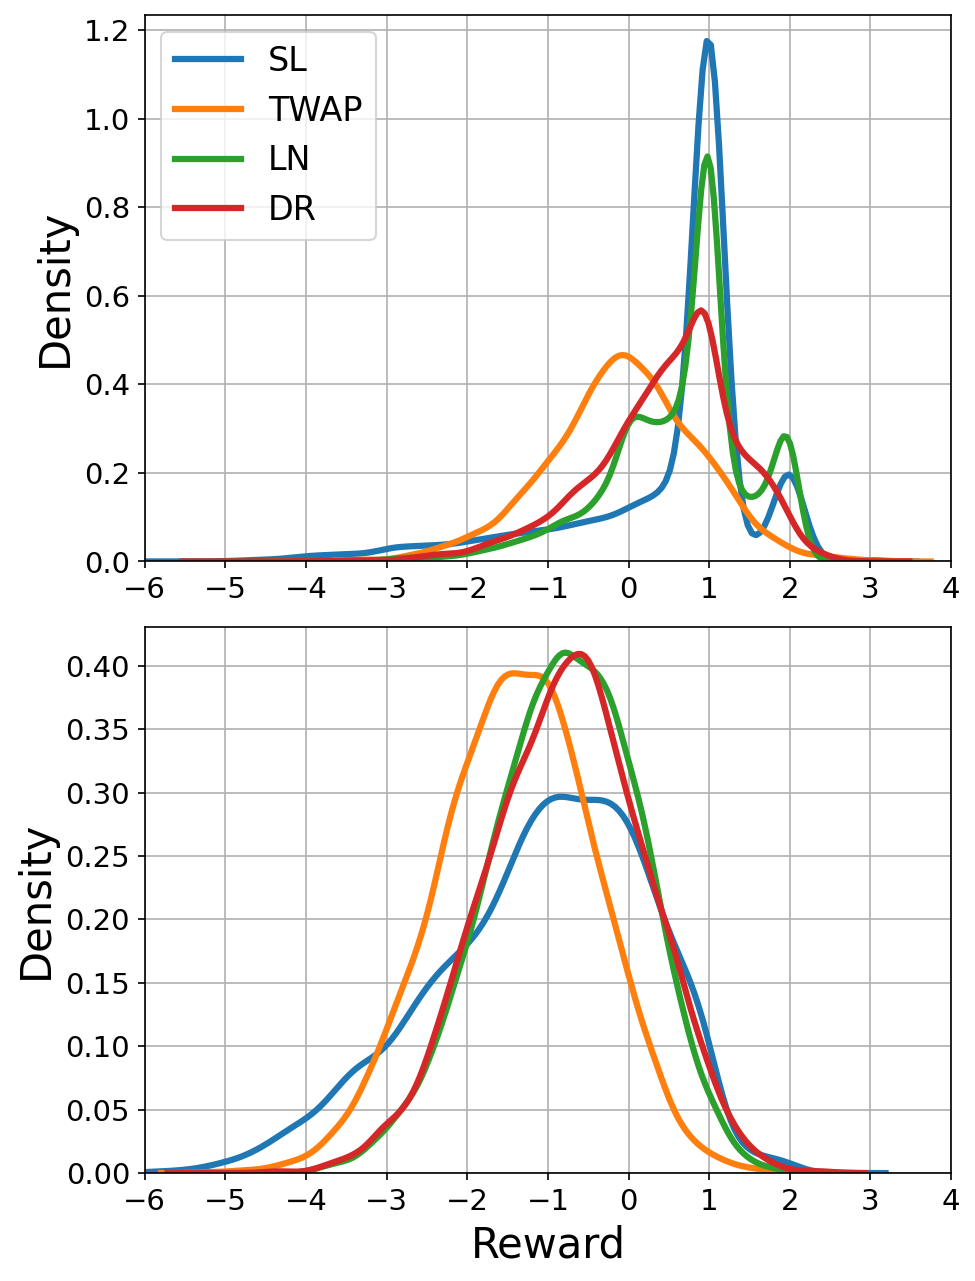

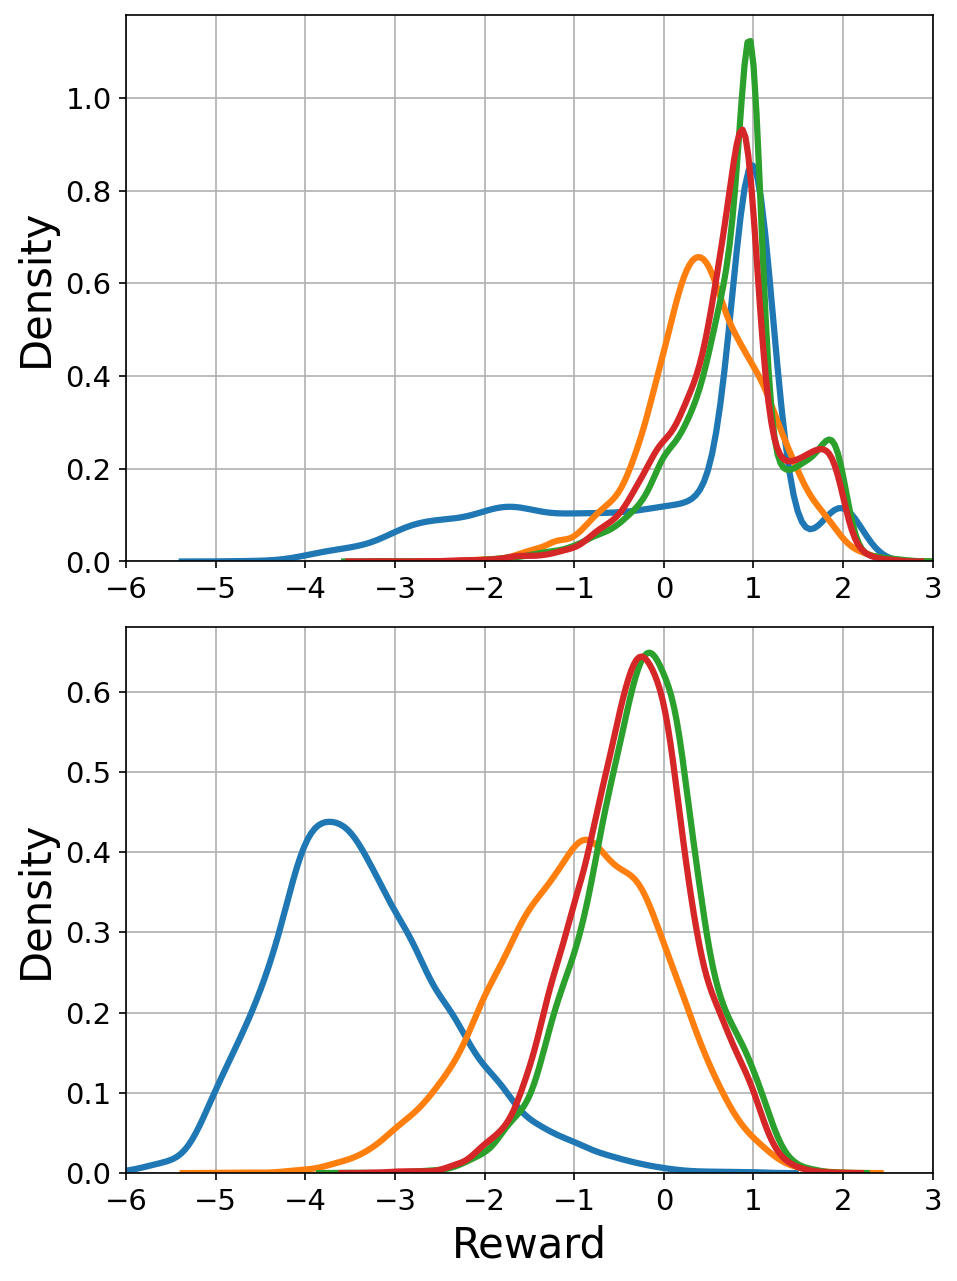

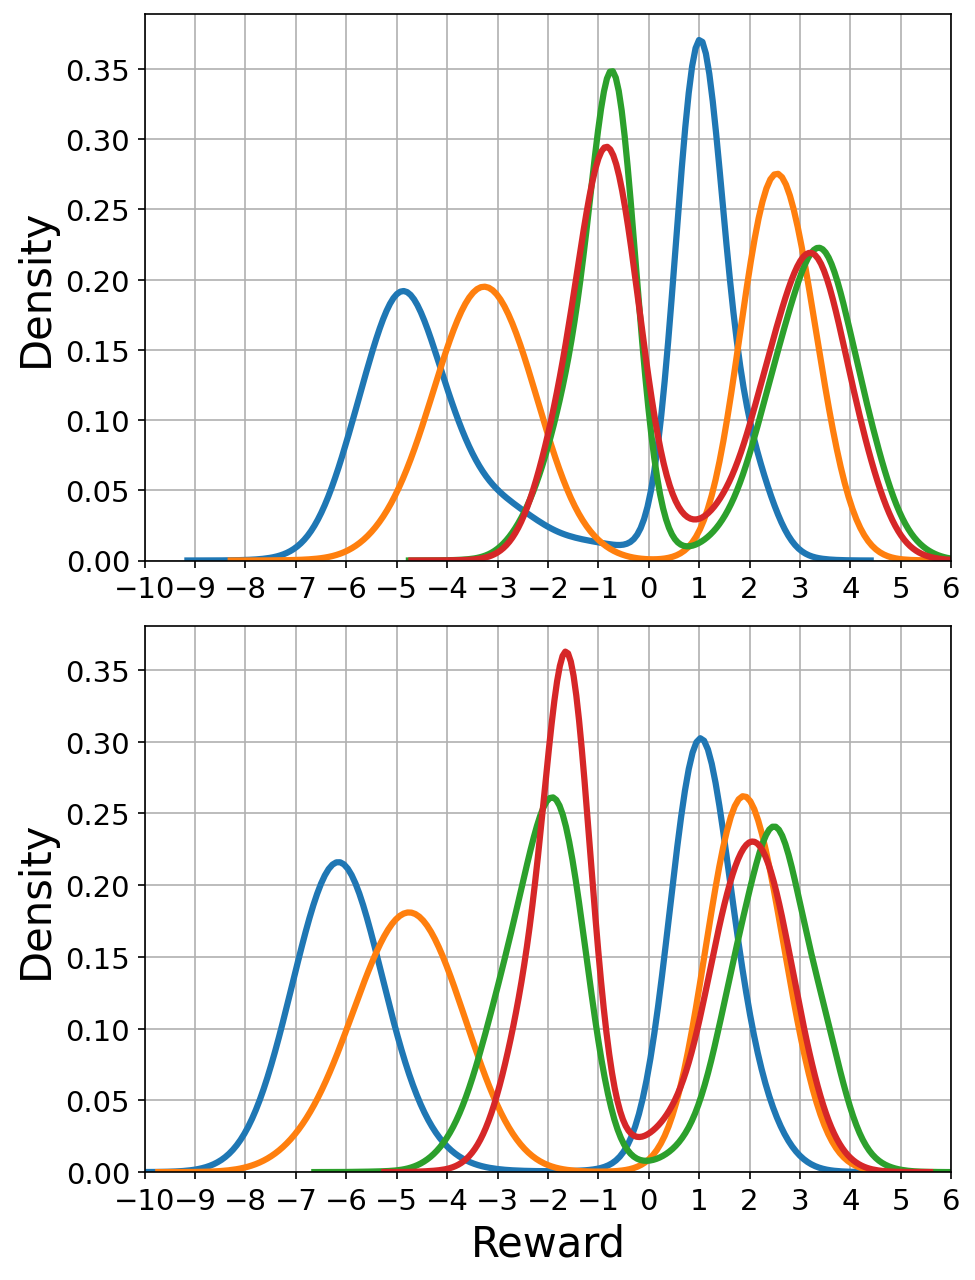

In [23]:

lots_list = [20, 60]
textwidth = 6.75
textheight = 9
scale = 3.2

agent_names = ['sl_agent', 'linear_sl_agent', 'log_normal', 'dirichlet']
# without dirichlet
# agent_names = ['sl_agent', 'linear_sl_agent', 'log_normal']
# agent_names = ['log_normal', 'sl_agent', 'linear_sl_agent']
for i, env in enumerate(['noise', 'flow', 'strategic']):
    print('#############')
    print('generating plots for ', env)
    fig, axs = plt.subplots(2, 1, figsize=(scale*0.3*textwidth, scale*0.3*textheight), dpi=300)
    for j, lots in enumerate(lots_list):
        ax = axs[j]
        for agent in agent_names:
            # names = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'actor_critic': 'RL'} 
            name_translation = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'log_normal': 'LN', 'dirichlet': 'DR'}
            try: 
                sns.kdeplot(data[env][lots][agent], fill=False, label=name_translation[agent], bw_adjust=1, linewidth=3, ax=ax)
            except: 
                print(f"no data available for {env}, {lots}, {agent}")
        if env == 'noise' and lots == 20:   
            ax.legend(prop={'size': 16}, loc='upper left')
        # set legend at the top of ech market. can comment this out if necessary. 
        # if j == 0:
            # ax.legend(prop={'size': 16}, loc='upper left')  
        fig.set_dpi(150)
        if j == 1:
            ax.set_xlabel('Reward', fontsize=20)
            # ax.set_xlabel('X', fontsize=20)
        # ax.set_title(f'{env}', fontsize=18)
        if i == 0:
            ax.set_ylabel('Density', fontsize=20)
        else:
            ax.set_ylabel('')
        # set density label everywhere
        # comment out if necessary 
        ax.set_ylabel('Density', fontsize=20)
        # if i == 0:
            # ax.set_title(f'Noise', fontsize=18)
        # if j == 0:
        # ax.set_title(f'#Lots={n_lots}', fontsize=18)
        tick_size = 14
        ax.tick_params(axis='x', labelsize=tick_size)
        ax.tick_params(axis='y', labelsize=tick_size)
        ax.grid()
        ax.set_xticks(np.arange(-10, 10, 1))
        if env == 'flow':
            ax.set_xlim(-6, 3)
        elif env == 'strategic':
            ax.set_xlim(-10, 6)
        else:
            ax.set_xlim(-6, 4)
    plt.tight_layout()
    plt.savefig(f'{parent_dir}/plots/reward_distribution_{env}_all_strategies.pdf')

In [12]:
data['noise'][5]['sl_agent']

array([ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
       -2.6,  1. ,  1. ,  1. ,  0.2,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. , -2.2,  1. ,  1. , -3. ,
        1. ])

<Axes: ylabel='Density'>

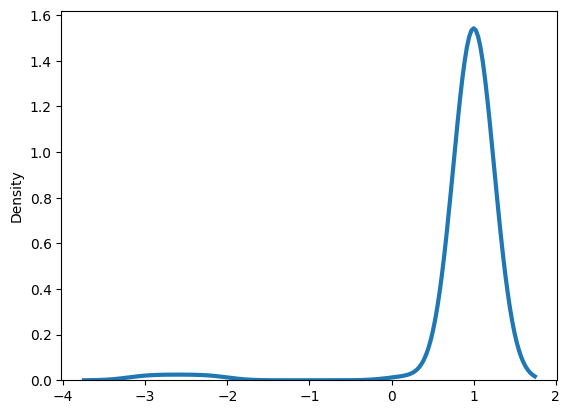

In [13]:
sns.kdeplot(data['noise'][5]['sl_agent'], fill=False, label=names[agent], bw_adjust=1, linewidth=3)

In [57]:
folder_path = f"{parent_dir}/latex_tables"
# n_lots = [20, 60]
for env in ['noise', 'flow', 'strategic']:
    if env == 'flow':
        print('tactical:')
    else:
        print(f'{env}: ')
    data_for_df = {}
    name_dict = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'actor_critic': 'RL'}
    # for agent in ['sl_agent', 'linear_sl_agent', 'actor_critic']:
    for agent in ['sl_agent', 'linear_sl_agent']:
        name = name_dict[agent]
        data_for_df[f'E[{name}]'] = []
        data_for_df[f'Std[{name}]'] = []
        for lots in lots_list:
            try:
                data_for_df[f'Std[{name}]'] += [np.std(data[env][lots][agent])]
                data_for_df[f'E[{name}]'] += [np.mean(data[env][lots][agent])]                
            except:
                print(f"no data available for {env}, {lots}, {agent}")
                data_for_df[f'Std[{name}]'] += [np.nan]
                data_for_df[f'E[{name}]'] += [np.nan]
                # print(data[env][lots][agent])
    # print(data_for_df)
    df = pd.DataFrame.from_dict(data_for_df).round(2)    
    df.index.name = 'Lots'
    df.index = lots_list
    display(df)
    df = df.round(2)
    latex_table = df.to_latex(float_format="%.2f")
    with open(f"{folder_path}/results_table_{env}.tex", "w") as f:
        f.write(latex_table)
    print()

noise: 


,E[SL],Std[SL],E[TWAP],Std[TWAP]
10,0.76,0.79,0.18,0.90
60,-1.05,1.27,-1.40,0.95



tactical:


,E[SL],Std[SL],E[TWAP],Std[TWAP]
10,0.81,0.72,0.64,0.64
60,-3.28,1.08,-0.93,0.95



strategic: 


,E[SL],Std[SL],E[TWAP],Std[TWAP]
10,-1.00,2.55,-0.01,2.89
60,-2.51,3.58,-1.38,3.41
